## Análisis de resultados.
En esta hoja de notas queremos comparar los resultados extraidos del DR3 de los obtenidos en el DR2 en el trabajo 
[Baumgardt et al., 2019](https://drive.google.com/file/d/1VtDW8WacV4sDh1wr_FGPmesjclg6zdbZ/view)

## Requirements

In [1]:
%load_ext autoreload
%autoreload 2


#@markdown ### Librerías y funciones auxiliares
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astroquery.vizier import Vizier
from dotenv import load_dotenv
from google.cloud import storage

# Añadir el directorio raíz del proyecto al sys.path
project_path = os.path.abspath(os.path.join(os.getcwd(), "../src"))  # Subir un nivel
if project_path not in sys.path:
    sys.path.append(project_path)
            

from hyper_velocity_stars_detection.jobs.utils import read_catalog_file
from hyper_velocity_stars_detection.jobs.google_jobs.utils import load_project
from hyper_velocity_stars_detection.cluster_detection.cluster_detection import get_distance_from_references
from hyper_velocity_stars_detection.cluster_detection.search_clustering_method import (
    ParamsDistribution,
    ParamsOptimizator,
)
from hyper_velocity_stars_detection.sources.utils import get_main_id


load_dotenv("../data/.env")
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../data/hvs-storage.json"
PATH = "../data/globular_clusters"
SELECTED_CLUSTERS = read_catalog_file(os.path.join(PATH, "mwgc.dat.txt"))

/home/santhiperbolico/Documentos/UCM/tfm-ucm-code/src/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Resultados Previos
Resultados en el DR2 en el trabajo [Baumgardt et al., 2019](https://drive.google.com/file/d/1VtDW8WacV4sDh1wr_FGPmesjclg6zdbZ/view)

In [5]:
v = Vizier(columns=["Name", "Rsun", "e_Rsun", "pmRA*", "e_pmRA*", "pmDE", "e_pmDE", "RV", "e_RV", "rho"])
v.ROW_LIMIT = -1
catalogs = v.get_catalogs("J/MNRAS/482/5138")
clusters_dr2 = catalogs[0].to_pandas()
clusters_dr2.Name = clusters_dr2.Name.str.lower()

clusters_dr2["parallax"] = 1 / (clusters_dr2.Rsun)
clusters_dr2["e_parallax"] = (1 / (clusters_dr2.Rsun - clusters_dr2.e_Rsun) - 1 / (clusters_dr2.Rsun + clusters_dr2.e_Rsun)) / 2
clusters_dr2 = clusters_dr2[["Name","parallax", "e_parallax", "pmRA_", "e_pmRA_", "pmDE", "e_pmDE", "RV", "e_RV", "rho", "Rsun", "e_Rsun"]]
clusters_dr2 = clusters_dr2.rename(columns={"pmRA_": "pmra", "pmDE": "pmdec", "parallax": "parallax_corrected"})
clusters_dr2["MAIN_ID"] = clusters_dr2["Name"].apply(get_main_id)
clusters_dr2

,Name,parallax_corrected,e_parallax,pmra,e_pmRA_,pmdec,e_pmDE,RV,e_RV,rho,Rsun,e_Rsun,MAIN_ID
0,ngc 104,0.225734,0.002038,5.25,0.01,-2.53,0.01,-17.209999,0.18,0.04,4.430000,0.04,NGC_104
1,ngc 288,0.100200,0.003317,4.22,0.01,-5.65,0.01,-44.830002,0.13,0.31,9.980000,0.33,NGC_288
2,ngc 362,0.109051,0.003094,6.71,0.01,-2.51,0.01,223.259995,0.28,-0.09,9.170000,0.26,NGC_362
3,whiting 1,0.031949,NaN,-0.04,0.12,-1.78,0.08,-130.410004,1.79,-0.09,31.299999,NaN,NAME_Whiting_1
4,ngc 1261,0.064558,NaN,1.61,0.02,-2.05,0.02,71.360001,0.24,0.19,15.490000,NaN,NGC_1261
...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,ngc 7089,0.095147,0.003354,3.51,0.01,-2.16,0.01,-3.720000,0.34,0.01,10.510000,0.37,M_2
150,ngc 7099,0.125000,0.008952,-0.73,0.01,-7.24,0.01,-185.190002,0.17,0.53,8.000000,0.57,M_30
151,pal 12,0.052632,NaN,-3.28,0.03,-3.31,0.03,27.910000,0.28,0.33,19.000000,NaN,Cl_Pal_12
152,pal 13,0.040323,NaN,1.64,0.09,0.25,0.07,25.870001,0.27,0.04,24.799999,NaN,GCl_124


Extraemos la información de la relación masa luminosidad de los cluster del trabajo [McLaughlin & van der Marel, 2005](https://vizier.cds.unistra.fr/viz-bin/VizieR-3?-source=J/ApJS/161/304/table13&-out.max=50&-out.form=HTML%20Table&-out.add=_r&-out.add=_RAJ,_DEJ&-sort=_r&-oc.form=sexa)

In [6]:
catalog2= "J/ApJS/161/304/table13"
catalog1 = "J/ApJS/161/304/clusters"
catalog2= "J/ApJS/161/304/models"

v = Vizier(columns=["**"])
v.ROW_LIMIT = -1
catalogs = v.get_catalogs([catalog1, catalog2])
clusters_ml = catalogs[0].to_pandas()
tbl_2 = catalogs[1].to_pandas()

properties = ["Ltot", "Mtot", "M_L"]
for prop in properties:
    df_p = tbl_2[["Cluster", prop, f"e_{prop}", f"E_{prop}"]].sort_values(["Cluster", f"e_{prop}", f"E_{prop}"])
    clusters_ml = pd.merge(clusters_ml, df_p.groupby("Cluster").first().reset_index(), on="Cluster")

clusters_ml.SName = clusters_ml.SName.str.lower()
clusters_ml

,recno,Cluster,RAJ2000,DEJ2000,SB,M,D,SName,logAge,__Fe_H_,...,e__M_L_6,Ltot,e_Ltot,E_Ltot,Mtot,e_Mtot,E_Mtot,M_L,e_M_L,E_M_L
0,1,FORNAX1,02 37 02.1,-34 11 00,SB,M,,name fornax 1,10.11,-2.20,...,0.147,4.12,0.03,0.03,4.40,0.05,0.05,1.915,0.163,0.163
1,2,FORNAX2,02 38 40.1,-34 48 05,SB,M,,name fornax 2,10.11,-1.78,...,0.145,4.80,0.04,0.04,5.07,0.05,0.05,1.867,0.156,0.156
2,3,FORNAX3,02 39 52.5,-34 16 08,SB,M,D,name fornax 3,10.11,-1.96,...,0.145,5.13,0.04,0.04,5.40,0.05,0.05,1.880,0.159,0.159
3,4,FORNAX4,02 40 07.9,-34 32 19,SB,M,D,name fornax 4,10.06,-1.90,...,0.076,4.94,0.05,0.05,5.18,0.05,0.05,1.717,0.075,0.075
4,5,FORNAX5,02 42 21.1,-34 06 05,SB,M,D,name fornax 5,10.11,-2.20,...,0.147,4.82,0.04,0.04,5.10,0.05,0.05,1.915,0.163,0.163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,212,SMC-NGC339,00 57 48.9,-74 28 00,SB,M,,ngc 339,9.80,-1.50,...,0.117,4.87,0.05,0.06,4.90,0.07,0.07,1.088,0.104,0.104
149,213,SMC-NGC361,01 02 12.8,-71 36 16,SB,M,,ngc 361,9.91,-1.45,...,0.109,5.18,0.08,0.09,5.30,0.08,0.10,1.313,0.101,0.101
150,214,SMC-NGC411,01 07 56.0,-71 46 05,SB,M,,ngc 411,9.15,-0.68,...,0.038,4.86,0.05,0.05,4.47,0.10,0.10,0.410,0.080,0.080
151,215,SMC-NGC416,01 07 59.0,-72 21 20,SB,M,,ngc 416,9.84,-1.44,...,0.102,5.14,0.04,0.04,5.21,0.05,0.05,1.181,0.084,0.084


In [4]:
df_clusters = pd.merge(clusters_dr2, clusters_ml, left_on=["Name"], right_on="SName", how="left")
df_clusters

,Name,parallax_corrected,e_parallax,pmra,e_pmRA_,pmdec,e_pmDE,RV,e_RV,rho,...,e__M_L_6,Ltot,e_Ltot,E_Ltot,Mtot,e_Mtot,E_Mtot,M_L,e_M_L,E_M_L
0,ngc 104,0.225734,0.002038,5.25,0.01,-2.53,0.01,-17.209999,0.18,0.04,...,0.224,5.68,0.01,0.01,6.05,0.04,0.04,2.348,0.239,0.239
1,ngc 288,0.100200,0.003317,4.22,0.01,-5.65,0.01,-44.830002,0.13,0.31,...,0.186,4.56,0.01,0.01,4.85,0.04,0.04,1.972,0.165,0.165
2,ngc 362,0.109051,0.003094,6.71,0.01,-2.51,0.01,223.259995,0.28,-0.09,...,0.190,5.23,0.01,0.01,5.53,0.04,0.04,2.013,0.171,0.171
3,whiting 1,0.031949,NaN,-0.04,0.12,-1.78,0.08,-130.410004,1.79,-0.09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ngc 1261,0.064558,NaN,1.61,0.02,-2.05,0.02,71.360001,0.24,0.19,...,0.180,4.94,0.00,0.00,5.20,0.04,0.04,1.928,0.158,0.158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,ngc 7089,0.095147,0.003354,3.51,0.01,-2.16,0.01,-3.720000,0.34,0.01,...,0.157,5.57,0.01,0.01,5.84,0.04,0.04,1.872,0.154,0.154
150,ngc 7099,0.125000,0.008952,-0.73,0.01,-7.24,0.01,-185.190002,0.17,0.53,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
151,pal 12,0.052632,NaN,-3.28,0.03,-3.31,0.03,27.910000,0.28,0.33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
152,pal 13,0.040323,NaN,1.64,0.09,0.25,0.07,25.870001,0.27,0.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Resultados DR3

In [32]:
CLUSTER_NAME = "ngc 6266"

cluster = [cl for cl in SELECTED_CLUSTERS if cl.name == CLUSTER_NAME][0]
project = load_project(cluster_name=cluster.name, project_id = os.getenv("PROJECT_ID"), bucket_name=os.getenv("BUCKET"),path=PATH)
print(str(project))

Las muestras analizadas de ngc 6266 son:
Muestras seleccionadas del objeto astronómico ngc 6266 con radio 1:
	 - df_1_c0 - Todas las estrellas seleccionadas: 25856.
	 - df_1_c1 - Las estrellas con errores de paralaje y pm menores al 10%: 5892.
	 - df_1_c2 - Las estrellas con un error de paralaje menor del 30% y de pm menores al 10%: 5892.
	 - df_1_c3 - Las estrellas con un error de paralaje menor del 10% y de pm menores al 20%.: 7365.

Muestras seleccionadas del objeto astronómico ngc 6266 con radio 6:
	 - df_6_c0 - Todas las estrellas seleccionadas: 98674.
	 - df_6_c1 - Las estrellas con errores de paralaje y pm menores al 10%: 8849.
	 - df_6_c2 - Las estrellas con un error de paralaje menor del 30% y de pm menores al 10%: 8884.
	 - df_6_c3 - Las estrellas con un error de paralaje menor del 10% y de pm menores al 20%.: 12468.

Se han encontrado 2 fuentes de rayos X.
Estimated number of clusters: 2
Estimated number of noise points: 5118
	 - Volumen total del cluster 0: 124.
	 - Volumen

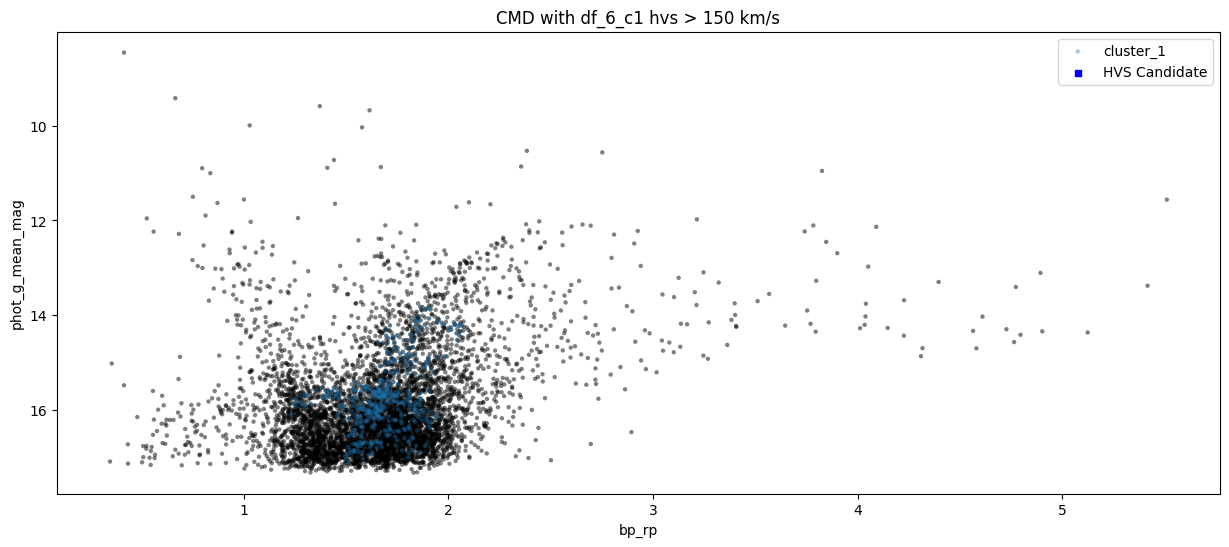

In [33]:
fig, ax = project.plot_cmd(
            hvs_candidates_name="df_6_c1",
            factor_sigma = 1,
            hvs_pm = 150,
            legend=True,
            clusters=project.clustering_results.main_label
)

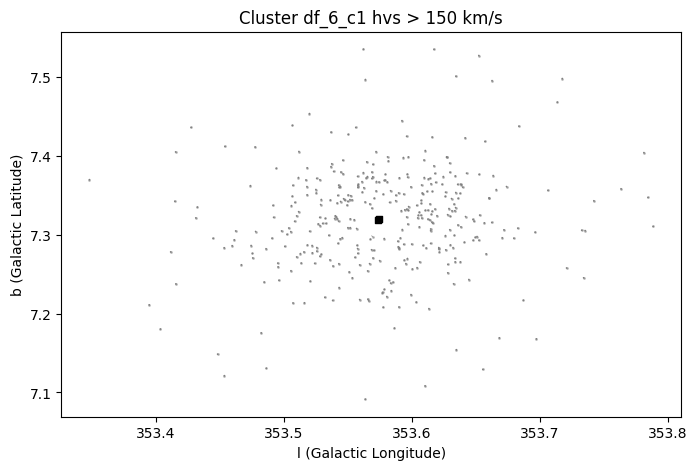

In [34]:
fig, ax = project.plot_cluster(
            hvs_candidates_name="df_6_c1",
            factor_sigma = 1,
            hvs_pm = 150,
            legend=False,
            factor_size=50
)

In [96]:
gc = project.clustering_results.gc
display(gc[["pmra", "pmdec", "parallax_corrected", "radial_velocity"]].describe())

,pmra,pmdec,parallax_corrected,radial_velocity
count,4353.000000,4353.000000,4353.000000,130.000000
mean,-3.160204,-4.026691,0.252437,-25.843921
std,0.238394,0.241927,0.086696,9.659331
min,-4.087909,-4.913193,0.000706,-42.919685
25%,-3.323893,-4.191290,0.200763,-30.304918
50%,-3.161026,-4.026085,0.253426,-26.571925
75%,-2.999856,-3.869218,0.306619,-23.357839
max,-2.239163,-3.028379,0.566189,53.491714


In [110]:
df_hvs_candidates = project.get_data("df_6_c1")
selected = project.clustering_results.selected_hvs(df_hvs_candidates, 1, 150)
selected["pm_kms"] - project.clustering_results.gc.pm_kms.mean()

260     165.087713
316     296.604899
391     247.985955
449     205.983710
477     244.837670
589     415.855424
605     316.208705
663     160.225098
697     222.945566
727     171.953212
759     195.909363
824     332.633766
851     182.831074
884     161.261785
896     201.449003
1180    167.230453
1266    155.650644
1327    177.970437
1348    243.978670
1373    239.707200
1405    168.891147
1580    463.664101
1637    217.714111
1793    184.068695
1797    174.593466
Name: pm_kms, dtype: float64

In [39]:
project.clustering_results.clustering

ClusteringDetection(model=HDBSCAN(min_cluster_size=82, min_samples=8), scaler=StandardScaler(), noise_method=None, labels_=array([-1, -1, -1, ..., -1, -1, -1], shape=(5677,)))

### Reclustering

*Añadir una comprobación de varianza extra-cluster, es decir, que exista diferencias entre cluster.*

In [214]:
data_name = "df_1_c2"

if project.get_data(data_name).shape[0] < 5000:
   data_name = "df_1_c0"

print("Volumen de datos: %i." %project.get_data(data_name).shape[0] )

columns_to_clus=["pmra", "pmdec", "parallax_corrected", "bp_rp", "phot_g_mean_mag"]
columns_to_clus=["pmra", "pmdec", "parallax_corrected"]
columns=["pmra", "pmdec", "parallax_corrected"]

print("Datos seleccionados: %s" %data_name)


PARAMS_OPTIMIZATOR = ParamsOptimizator(
    [
       # ParamsDistribution("dbscan", ["standard"], ["isolation_forest_method",None], None),
       # ParamsDistribution("hdbscan", ["standard"], ["isolation_forest_method",None], None),
        ParamsDistribution(
            "gaussian_mixture",
            ["standard"],
            ["isolation_forest_method", "local_outlier_method", None],
            None,
        ),
    ]
)

clustering = project.optimize_cluster_detection(
    data_name=data_name,
    columns=columns, 
    columns_to_clus=columns_to_clus,
    max_cluster=5,
    n_trials=500,
    params_methods = PARAMS_OPTIMIZATOR,
    group_labels=False,
    reference_cluster=clusters_dr2.loc[clusters_dr2.MAIN_ID == project.name, columns].iloc[0],
)
print(project)

[I 2025-06-13 22:06:22,403] A new study created in memory with name: no-name-90e7b544-c21a-4c7b-afda-968db70306bb
[I 2025-06-13 22:06:22,419] Trial 0 finished with value: 8.472114431069393 and parameters: {'params_distribution': 'gaussian_mixture', 'gaussian_mixture_n_components': 3, 'gaussian_mixture_covariance_type': 'full', 'gaussian_mixture_tol': 0.0007198018726304777, 'gaussian_mixture_max_iter': 252, 'gaussian_mixture_scaler_method': 'standard', 'gaussian_mixture_noise_method': None}. Best is trial 0 with value: 8.472114431069393.
[W 2025-06-13 22:06:22,431] Trial 1 failed with parameters: {'params_distribution': 'gaussian_mixture', 'gaussian_mixture_n_components': 5, 'gaussian_mixture_covariance_type': 'tied', 'gaussian_mixture_tol': 3.3120802749533894e-05, 'gaussian_mixture_max_iter': 287, 'gaussian_mixture_scaler_method': 'standard', 'gaussian_mixture_noise_method': None} because of the following error: The value nan is not acceptable.
[W 2025-06-13 22:06:22,432] Trial 1 faile

Volumen de datos: 452.
Datos seleccionados: df_1_c0


[I 2025-06-13 22:06:22,747] Trial 6 finished with value: 3.6685566348883425 and parameters: {'params_distribution': 'gaussian_mixture', 'gaussian_mixture_n_components': 4, 'gaussian_mixture_covariance_type': 'tied', 'gaussian_mixture_tol': 0.000463155153359358, 'gaussian_mixture_max_iter': 171, 'gaussian_mixture_scaler_method': 'standard', 'gaussian_mixture_noise_method': 'isolation_forest_method'}. Best is trial 3 with value: 3.242430401985735.
[I 2025-06-13 22:06:22,954] Trial 7 finished with value: 4.174085352627699 and parameters: {'params_distribution': 'gaussian_mixture', 'gaussian_mixture_n_components': 3, 'gaussian_mixture_covariance_type': 'tied', 'gaussian_mixture_tol': 0.00017732292000328573, 'gaussian_mixture_max_iter': 113, 'gaussian_mixture_scaler_method': 'standard', 'gaussian_mixture_noise_method': 'isolation_forest_method'}. Best is trial 3 with value: 3.242430401985735.
[I 2025-06-13 22:06:22,974] Trial 8 finished with value: 6.466999492170252 and parameters: {'params

Las muestras analizadas de ngc 6981 son:
Muestras seleccionadas del objeto astronómico ngc 6981 con radio 1:
	 - df_1_c0 - Todas las estrellas seleccionadas: 584.
	 - df_1_c1 - Las estrellas con errores de paralaje y pm menores al 10%: 241.
	 - df_1_c2 - Las estrellas con un error de paralaje menor del 30% y de pm menores al 10%: 241.
	 - df_1_c3 - Las estrellas con un error de paralaje menor del 10% y de pm menores al 20%.: 262.

Muestras seleccionadas del objeto astronómico ngc 6981 con radio 6:
	 - df_6_c0 - Todas las estrellas seleccionadas: 221.
	 - df_6_c1 - Las estrellas con errores de paralaje y pm menores al 10%: 58.
	 - df_6_c2 - Las estrellas con un error de paralaje menor del 30% y de pm menores al 10%: 59.
	 - df_6_c3 - Las estrellas con un error de paralaje menor del 10% y de pm menores al 20%.: 61.

Se han encontrado 0 fuentes de rayos X.
Estimated number of clusters: 4
Estimated number of noise points: 103
	 - Volumen total del cluster 0: 116.
	 - Volumen total del clus

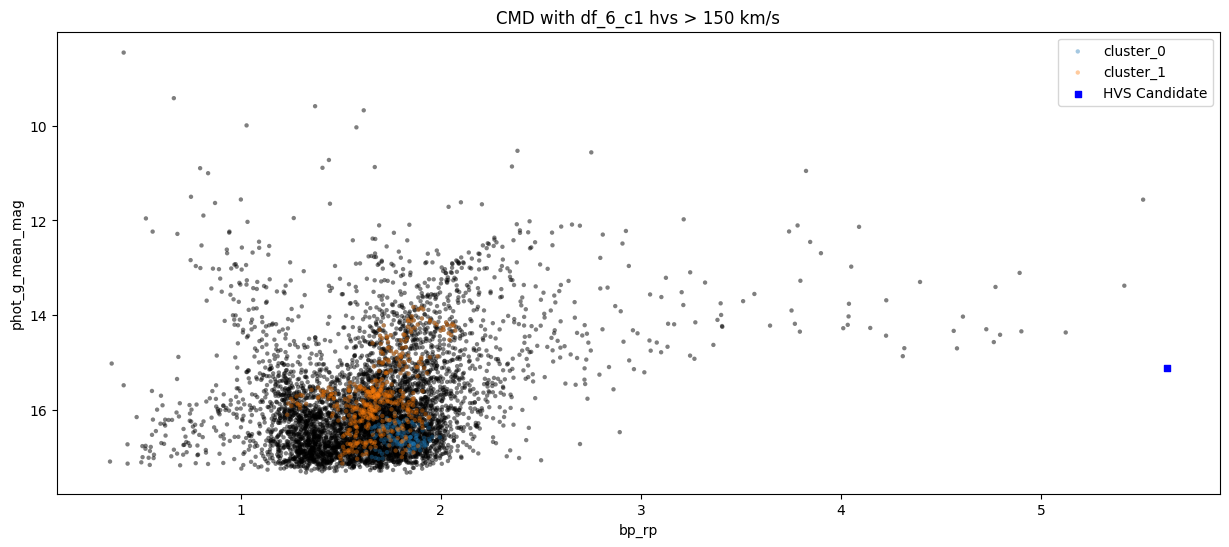

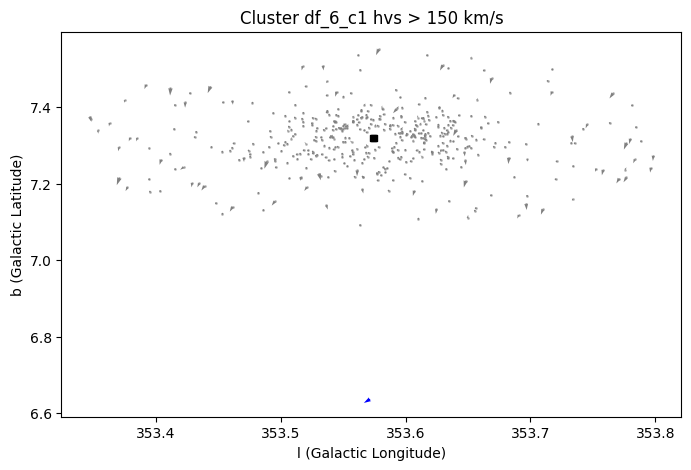

In [38]:
fig, ax = project.plot_cmd(
            hvs_candidates_name="df_6_c1",
            factor_sigma = 2,
            hvs_pm = 150,
            legend=True,
            clusters= None
)

fig, ax = project.plot_cluster(
            hvs_candidates_name="df_6_c1",
            factor_sigma = 2,
            hvs_pm = 150,
            legend=False,
            factor_size=50
)

In [43]:
columns=["pmra", "pmdec", "parallax_corrected"]

project.clustering_results.set_main_label(reference_cluster=clusters_dr2.loc[clusters_dr2.MAIN_ID == project.name, columns], group_labels=True)
project.clustering_results.set_main_label(reference_cluster=clusters_dr2.loc[clusters_dr2.MAIN_ID == project.name, columns])

# project.clustering_results.set_main_label(1)

project.clustering_results.main_label

1

In [44]:
project.clustering_results.get_labels(return_counts=True), project.clustering_results.main_label

((array([0, 1]), array([124, 435])), 1)

In [45]:
gc = project.clustering_results.gc
display(gc[["pmra", "pmdec", "parallax_corrected", "radial_velocity"]].describe())

,pmra,pmdec,parallax_corrected,radial_velocity
count,435.000000,435.000000,435.000000,54.000000
mean,-4.941766,-2.969522,0.181814,-74.960139
std,0.265746,0.282680,0.047998,9.306544
min,-5.871296,-4.202737,0.036479,-106.324420
25%,-5.131990,-3.148501,0.151154,-80.821629
50%,-4.937306,-2.959204,0.185303,-73.059250
75%,-4.751496,-2.783876,0.212261,-68.637034
max,-4.355546,-2.016059,0.321882,-58.230130


In [46]:
gc = project.clustering_results.remove_outliers_gc()
display(gc[["pmra", "pmdec", "parallax_corrected"]].describe())

,pmra,pmdec,parallax_corrected
count,374.000000,374.000000,374.000000
mean,-4.924410,-2.958271,0.183652
std,0.247035,0.245187,0.047069
min,-5.570437,-3.618361,0.068004
25%,-5.104518,-3.129404,0.152112
50%,-4.920425,-2.939379,0.185936
75%,-4.743600,-2.787489,0.214076
max,-4.355546,-2.281375,0.308998


In [47]:
project.save_project(to_zip=True)

client = storage.Client(project=os.getenv("PROJECT_ID"))
bucket = client.bucket(os.getenv("BUCKET"))
blob_path = project.astro_object.name+".zip"
path_zip = os.path.join(project.path, blob_path)

blob = bucket.blob(blob_path)
blob.upload_from_filename(path_zip)